In [4]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib import patches
import time
import scipy

if scipy.__version__=='0.9.0' or scipy.__version__=='0.10.1':
    from scipy.sparse.linalg import eigs as Eigens
else:
    from scipy.sparse.linalg.eigen.arpack import eigs as Eigens

### Function to read the data

In [ ]:
def read_file(fname,Nfr=-1):
    tmp= open(fname+'.txt', 'rb');a=tmp.read();tmp.close();T=len(a) # Just to know how many frames (T) are there in the file
    if Nfr!=-1:
        T=np.min((T,Nfr))
    dim=[30,30] # Dimension of each frame
    N_fr=dim[0]*dim[1] # size of the input vector
    yuvfile= open(fname+'.yuv', 'rb') # Opening the video file
    door_state_file= open(fname+'.txt', 'rb') # Opening the annotation file
    TARGET=np.zeros((T,3))
    FRAMES=np.zeros((T,N_fr))
    for t in tqdm(range(T)): # for each frame    
        fr2=np.zeros(N_fr) 
        frame = yuvfile.read(N_fr)
        for i in range(N_fr):
            fr2[i]=frame[i]
        # ----------------------------------    
        fr2=fr2/255.0 # Normalizing the pixel values to [0,1]
        FRAMES[t,:]=fr2
        TARGET[t,int(door_state_file.read(1))] = 1 # setting the desired output class to 1
    
    return np.array_split(FRAMES, 100),np.array_split(TARGET, 100)

### Linear Regression (Ridge regression) https://en.wikipedia.org/wiki/Ridge_regression 

In [ ]:
def linreg (xTx,xTy,xlen,regu=0.001):
    lmda = regu**2 * xlen # regularization parameter
    inv_xTx = np.linalg.inv(xTx + lmda * np.eye(xTx.shape[0]))
    beta = np.dot(inv_xTx, xTy)
    return beta

### Random weight initialization 

In [ ]:
def init_weights(input_dim,res_size,K_in, K_rec,insca,spra,bisca):
    #---------- Initializing W_in ---------
    if K_in == -1:
        W_in = insca * (np.random.rand(res_size, input_dim) * 2 - 1)
    else:
        Ico=0
        nrentries = np.int32(res_size*K_in)
        ij = np.zeros((2,nrentries))
        datavec =  insca * (np.random.rand(nrentries)* 2 - 1)
        for en in range(res_size):
            Per=np.random.permutation(input_dim)[:K_in]
            ij[0][Ico:Ico+K_in]=en
            ij[1][Ico:Ico+K_in]=Per
            Ico+=K_in
        W_in = scipy.sparse.csc_matrix((datavec, np.int_(ij)),dtype='float64')
        if K_in > input_dim/2:
            W_in=W_in.todense()
        

    #---------- Initializing W_res ---------
    converged = False
    attempts = 50
    while not converged and attempts > 0:  
        if K_rec == -1:
            W_res = np.random.randn(res_size, res_size)
        else:
            Ico=0
            nrentries = np.int32(res_size*K_rec)
            ij = np.zeros((2,nrentries))
            datavec =  np.random.randn(nrentries)
            for en in range(res_size):
                Per=np.random.permutation(res_size)[:K_rec]
                ij[0][Ico:Ico+K_rec]=en
                ij[1][Ico:Ico+K_rec]=Per
                Ico+=K_rec
            W_res = scipy.sparse.csc_matrix((datavec, np.int_(ij)),dtype='float64')
            if K_rec > res_size/2:
                W_res=W_res.todense()
        try:
            we =  Eigens(W_res,return_eigenvectors=False,k=6)
            converged = True
        except:
            print ("WARNING: No convergence! Redo %i times ... " % (attempts-1))
            attempts -=1
            pass

    W_res *= (spra / np.amax(np.absolute(we)))
    #---------- Initializing W_bi ---------
    W_bi = bisca * (np.random.rand(res_size) * 2 - 1)
    
    return W_in,W_res,W_bi

### Reservoir execution (online)

In [241]:
def rcn_infer(w_in,w_res,w_bi,w_out,leak,r_prev,u):
    if scipy.sparse.issparse(w_in): # applying input weights to the input. Sparse and dense matrix multiplication is different in Python 
        a1 = w_in * u 
    else:
        a1=np.dot(w_in, u)
    a2 = w_res * r_prev # applying recurrent weights to the previous reservoir states
    r_now = np.tanh(a1 + a2 + w_bi) # adding bias and applying activation function
    r_now = (1 - leak) * r_prev + leak * r_now # applying leak rate
    y = np.dot(np.append([1],r_now),w_out) # applying the output weight
    return r_now,y

### Reservoir execution (offline)

In [ ]:
def res_exe(W_in,W_res,W_bi,leak,U): 
    T=U.shape[0] # size of the input vector
    nres=W_res.shape[0] # Getting the size of the network (= 100)
    R=np.zeros((T+1,nres),dtype='float64') # Initializing the RCN output matrix (one extra frame for the warming up)
    for t in range(T): # for each frame
        if scipy.sparse.issparse(W_in):
            a=W_in*U[t,:]
        else:
            a=np.dot(W_in,U[t,:])
        
        if scipy.sparse.issparse(W_res):
            b=W_res*R[t,:]
        else:
            b=np.dot(W_res,R[t,:])
        R[t+1,:] = np.tanh(a+b+W_bi)
        R[t+1,:] = (1-leak)*R[t,:] + leak*R[t+1,:]
    R=np.concatenate((np.ones((R.shape[0],1)),R),1)    
    return R[1:,:] # returns the reservoir output and the desired output

### Load the data

In [6]:
X,y = read_file('/scratch/gpfs/aj17/datasets/Little_Sister/dataset/Seq_1')
X_test,y_test = read_file('/scratch/gpfs/aj17/datasets/Little_Sister/dataset/Seq_2',10000)

100%|██████████| 10000/10000 [00:01<00:00, 7715.53it/s]


In [7]:
X_train,y_train=X[:80],y[:80]
X_valid,y_valid=X[80:],y[80:]

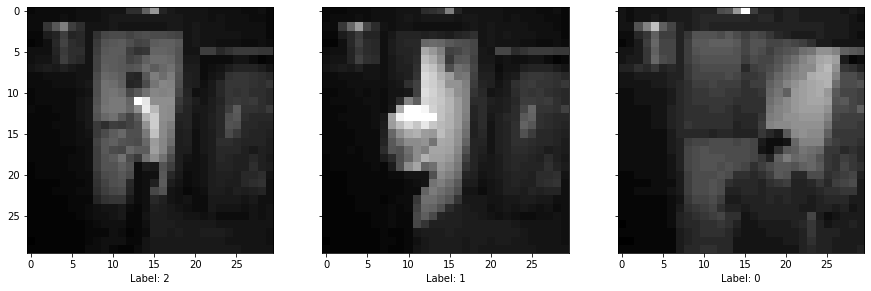

In [237]:
num_row = 1
num_col = 3  # plot images
fig, axes = plt.subplots(num_row, num_col, sharex='all', sharey='all',
                         figsize=(15, 5))
idx = (0, 50, 2000)
for k in range(3):
    ax = axes[k]
    im = ax.imshow(X_train[8][idx[k], :].reshape(30, 30), cmap='gray')
    ax.set(xlabel='Label: %s' % (str(np.argmax(y_train[8][idx[k]]))))
    ax.grid(False)


### Solve the problem using Linear Regression

#### Collect xTx and xTy

In [242]:
input_dim = X_train[0].shape[1]
output_dim = y_train[0].shape[1]

t1 = time.time()  # Just to have the time
xTx = np.zeros((input_dim + 1, input_dim + 1), dtype='float32')
xTy = np.zeros((input_dim + 1, output_dim), dtype='float32')
xlen = 0

for U,D in tqdm(zip(X_train,y_train), desc='Train...', ascii=True, dynamic_ncols=True):
    xlen += U.shape[0]
    U_exp = np.concatenate((np.ones((U.shape[0],1)),U),1) # add a bias element for better training
    xTx += np.dot(U_exp.T, U_exp)
    xTy += np.dot(U_exp.T, D)
t2 = time.time()

Train...: 80it [00:01, 53.56it/s]


#### Calulate the regression coefficients

In [261]:
regu = 0.1
beta_lin = linreg(xTx, xTy, xlen, regu) # Calulate the regression coefficients

### Show one example of validation

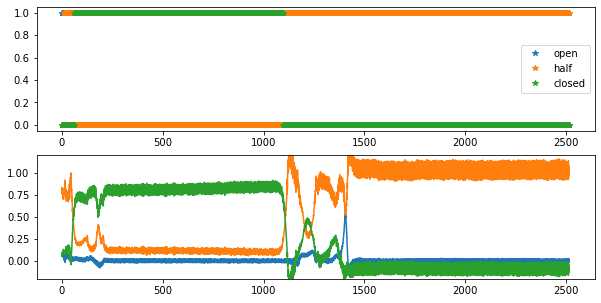

In [262]:
idx = 8
U,D = X_valid[idx],y_valid[idx]
U_exp = np.concatenate((np.ones((U.shape[0],1)),U),1)
y_out = np.dot(U_exp,beta_lin)

# Plot the results

fig,axs=plt.subplots(ncols=1,nrows=2,figsize=(10,5))
axs[0].plot(D,'*')
axs[0].legend(['open','half','closed'])

axs[1].plot(y_out)
_=axs[1].set(ylim=[-0.2,1.2])

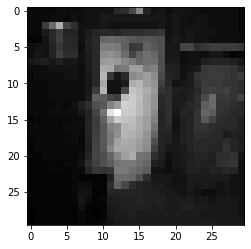

In [252]:
plt.imshow(X_valid[idx][1300, :].reshape(30, 30), cmap='gray')

In [111]:
Err={'train':[0,0],
     'valid':[0,0]}

for U,D in tqdm(zip(X_train,y_train), dynamic_ncols=True): # Loop over each training sample
    
    for t in range(U.shape[0]): # Loop over every frame of the current sample
        u=U[t:t+1,:]
        d=D[t:t+1,:]
        
        u_exp = np.concatenate((np.ones((u.shape[0],1)),u),1) # Add an extended 1 for bias
        y_out_lin = np.dot(u_exp,beta_lin) # Apply regression coeffs to the input
        
        Err['train'][0]+= np.argmax(y_out_lin)!=np.argmax(d)
        Err['train'][1]+=1

for U,D in tqdm(zip(X_valid,y_valid), ascii=True, dynamic_ncols=True): # The same as above but for validation
    
    for t in range(U.shape[0]):
        u=U[t:t+1,:]
        d=D[t:t+1,:]
        
        u_exp = np.concatenate((np.ones((u.shape[0],1)),u),1)
        y_out_lin = np.dot(u_exp,beta_lin)
        Err['valid'][0]+= np.argmax(y_out_lin)!=np.argmax(d)
        Err['valid'][1]+=1

        
        
print ('Train error rate: %.3f - Valid error rate: %.3f' % (Err['train'][0]*100/Err['train'][1],Err['valid'][0]*100/Err['valid'][1]))


80it [00:04, 17.99it/s]
20it [00:01, 18.09it/s]

Train error rate: 0.422 - Valid error rate: 0.391


## Set up RCN parameters and initilize the weights

In [195]:
insca = 1 # Scaling the input weights W_in
bisca = 0 # Scaling the bias weights W_bi
spra = 0  # Scaling the recurrent weights W_res
leak = 1  # Leakage
k_in = 50 # Number of input connections to each reservoir node
k_rec= 50 # Number of recurrent connections to each reservoir node
res_size = 500 # Reservoir size

W_in,W_res,W_bi=init_weights(input_dim,res_size,k_in, k_rec,insca,spra,bisca)

### Change the RCN parameters and test the Impluse response 

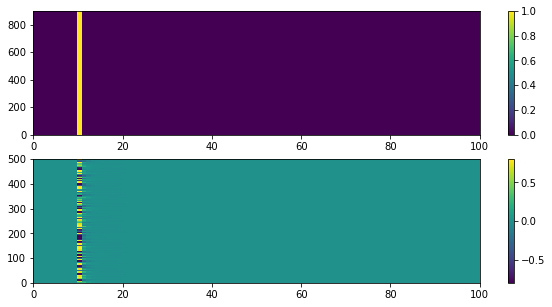

In [269]:
U=np.zeros((100,900))
U[10,:]=1

x=res_exe(W_in,W_res,W_bi,leak,U)

fig,axs = plt.subplots(ncols=1,nrows=2,figsize=(10,5))
a=axs[0].pcolormesh(U.T);fig.colorbar(a,ax=axs[0])
b=axs[1].pcolormesh(x[:,1:].T);fig.colorbar(b,ax=axs[1])

#### Collect xTx and xTy

In [198]:
input_dim = X_train[0].shape[1]
output_dim = y_train[0].shape[1]

t1 = time.time()  # Just to have the time
xTx = np.zeros((res_size + 1, res_size + 1), dtype='float32')
xTy = np.zeros((res_size + 1, output_dim), dtype='float32')
xlen = 0

for U,D in tqdm(zip(X_train,y_train), desc='Train...', ascii=True, dynamic_ncols=True):
    xlen += U.shape[0]

    x = res_exe(W_in,W_res,W_bi,leak,U)
    xTx += np.dot(x.T, x)
    xTy += np.dot(x.T, D)
t2 = time.time()

Train...: 80it [00:26,  3.06it/s]


In [199]:
beta = linreg(xTx, xTy, xlen, regu)

In [200]:
idx = 8
U,D = X_valid[idx],y_valid[idx]
x = res_exe(W_in,W_res,W_bi,leak,U)
y_out = np.dot(x,beta)

[(-0.2, 1.2)]

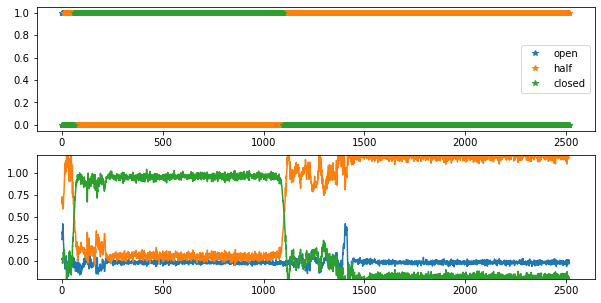

In [201]:
fig,axs=plt.subplots(ncols=1,nrows=2,figsize=(10,5))
axs[0].plot(D,'*')
axs[0].legend(['open','half','closed'])

axs[1].plot(y_out)
axs[1].set(ylim=[-0.2,1.2])

In [203]:
Err={'train':[0,0],
     'valid':[0,0]}

for U,D in tqdm(zip(X_train,y_train), dynamic_ncols=True):
    
    for t in range(U.shape[0]):
        u=U[t:t+1,:]
        d=D[t:t+1,:]
        
        x = res_exe(W_in,W_res,W_bi,leak,u)
        y_out = np.dot(x,beta)
        Err['train'][0]+= np.argmax(y_out)!=np.argmax(d)
        Err['train'][1]+=1

for U,D in tqdm(zip(X_valid,y_valid), ascii=True, dynamic_ncols=True):
    
    for t in range(U.shape[0]):
        u=U[t:t+1,:]
        d=D[t:t+1,:]
        
        x = res_exe(W_in,W_res,W_bi,leak,u)
        y_out = np.dot(x,beta)
        Err['valid'][0]+= np.argmax(y_out)!=np.argmax(d)
        Err['valid'][1]+=1

        
        
print ('Train error rate: %.3f - Valid error rate: %.3f' % (Err['train'][0]*100/Err['train'][1],Err['valid'][0]*100/Err['valid'][1]))


80it [00:39,  2.04it/s]
20it [00:09,  2.04it/s]

Train error rate: 0.412 - Valid error rate: 0.386


In [230]:
# Adaptive

In [231]:
for U,D in tqdm(zip(X_valid,y_valid), desc='Train...', ascii=True, dynamic_ncols=True):
    xlen += U.shape[0]

    x = res_exe(W_in,W_res,W_bi,leak,U)
    xTx += np.dot(x.T, x)
    xTy += np.dot(x.T, D)
    
#     beta = linreg(xTx, xTy, xlen, regu)
t2 = time.time()

Train...: 20it [00:06,  3.10it/s]


In [234]:
beta = linreg(xTx, xTy, xlen, regu)

In [233]:
Err={'train':[0,0],
     'valid':[0,0]}

for U,D in tqdm(zip(X_train,y_train), dynamic_ncols=True):
    
    for t in range(U.shape[0]):
        u=U[t:t+1,:]
        d=D[t:t+1,:]
        
        x = res_exe(W_in,W_res,W_bi,leak,u)
        y_out = np.dot(x,beta)
        Err['train'][0]+= np.argmax(y_out)!=np.argmax(d)
        Err['train'][1]+=1

for U,D in tqdm(zip(X_valid,y_valid), ascii=True, dynamic_ncols=True):
    
    for t in range(U.shape[0]):
        u=U[t:t+1,:]
        d=D[t:t+1,:]
        
        x = res_exe(W_in,W_res,W_bi,leak,u)
        y_out = np.dot(x,beta)
        Err['valid'][0]+= np.argmax(y_out)!=np.argmax(d)
        Err['valid'][1]+=1

        
        
print ('Train error rate: %.3f - Valid error rate: %.3f' % (Err['train'][0]*100/Err['train'][1],Err['valid'][0]*100/Err['valid'][1]))


80it [00:30,  2.62it/s]
20it [00:07,  2.52it/s]

Train error rate: 0.306 - Valid error rate: 0.288
